# Data downloading

In [1]:
import zipfile
from torch.utils.data import Dataset
import torch
import os
import pandas  as pd
import numpy as np
from zipfile import ZipFile
import requests
import sklearn
import random

class Download():
    def __init__(self,
                 root: str,
                 file_size: str = '100k',
                 download: bool = True,
                 ) -> None:
        self.root = root
        self.download = download
        self.file_size_url = file_size

        if self.file_size_url == '100k':
            self.file_url = 'ml-latest' if self.file_size_url == '20m' else 'ml-latest-small'
            self.fname = os.path.join(self.root, self.file_url, 'ratings.csv')

        if self.download or not os.path.isfile(self.fname):
            self._download_movielens()
        self.df = self._read_ratings_csv()

    def _download_movielens(self) -> None:
        '''
        Download dataset from url, if there is no root dir, then mkdir root dir.
        After downloading, it wil be extracted
        :return: None
        '''
        file = self.file_url + '.zip'
        url = ("http://files.grouplens.org/datasets/movielens/" + file)
        req = requests.get(url, stream=True)
        print('Downloading MovieLens dataset')
        if not os.path.exists(self.root):
            os.makedirs(self.root)
        with open(os.path.join(self.root, file), mode='wb') as fd:
            for chunk in req.iter_content(chunk_size=None):
                fd.write(chunk)
        with ZipFile(os.path.join(self.root, file), "r") as zip:
            # Extract files
            print("Extracting all the files now...")
            zip.extractall(path=self.root)
            print("Downloading Complete!")

    def _read_ratings_csv(self) -> pd.DataFrame:
        '''
        at first, check if file exists. if it doesn't then call _download().
        it will read ratings.csv, and transform to dataframe.
        it will drop columns=['timestamp'].
        :return:
        '''
        print("Reading file")
        if not os.path.isfile(self.fname):
            self._download_movielens()

        if self.file_size_url == '100k':
            df = pd.read_csv(self.fname, sep=',')
        else:
            df = pd.read_csv(self.fname, sep="::", header=None,
                               names=['userId', 'movieId', 'ratings', 'timestamp'])
        df = df.drop(columns=['timestamp'])
        print("Reading Complete!")
        return df

    def split_train_test(self) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
        '''
        pick each unique userid row, and add to the testset, delete from trainset.
        :return: (pd.DataFrame,pd.DataFrame,pd.DataFrame)
        '''
        train_dataframe = self.df
        test_dataframe = self.df.sample(frac=1).drop_duplicates(['userId'])
        tmp_dataframe = pd.concat([train_dataframe, test_dataframe])
        train_dataframe = tmp_dataframe.drop_duplicates(keep=False)

        # explicit feedback -> implicit feedback
        # ignore warnings
        np.warnings.filterwarnings('ignore')
        train_dataframe.loc[:, 'rating'] = 1
        test_dataframe.loc[:, 'rating'] = 1

        print(f"len(total): {len(self.df)}, len(train): {len(train_dataframe)}, len(test): {len(test_dataframe)}")
        return self.df, train_dataframe, test_dataframe,

In [2]:
# root path for dataset
import warnings
np.warnings = warnings
root_path='./content/'

# load dataframe
dataset = Download(root=root_path)
total_dataframe, train_dataframe, test_dataframe = dataset.split_train_test()


Extracting all the files now...
Reading file
Reading Complete!
len(total): 100836, len(train): 100226, len(test): 610


# Zipping the raw data

In [3]:
!zip -r data100k.zip ml-latest-small

	zip warning: name not matched: ml-latest-small

zip error: Nothing to do! (try: zip -r data100k.zip . -i ml-latest-small)


# Data exploration

In [4]:
train_dataframe

,userId,movieId,rating
0,1,1,1.0
1,1,3,1.0
2,1,6,1.0
3,1,47,1.0
4,1,50,1.0
...,...,...,...
100831,610,166534,1.0
100832,610,168248,1.0
100833,610,168250,1.0
100834,610,168252,1.0


In [5]:
test_dataframe

,userId,movieId,rating
84754,548,74532,1.0
14194,91,384,1.0
515,4,4967,1.0
72319,466,6281,1.0
7537,51,1834,1.0
...,...,...,...
33657,228,1373,1.0
91736,595,1278,1.0
61556,407,1196,1.0
83478,531,2640,1.0


## Merging dataset of the movie titles with ids data

In [6]:
import pandas as pd
movies = pd.read_csv("./content/ml-latest-small/movies.csv")
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [7]:
merged_dataset = pd.merge(test_dataframe, movies, how='inner', on='movieId')
merged_dataset

,userId,movieId,rating,title,genres
0,548,74532,1.0,Cop Out (2010),Action|Comedy|Crime
1,91,384,1.0,Bad Company (1995),Action|Crime|Drama
2,4,4967,1.0,No Man's Land (2001),Drama|War
3,466,6281,1.0,Phone Booth (2002),Drama|Thriller
4,51,1834,1.0,"Spanish Prisoner, The (1997)",Crime|Drama|Mystery|Thriller
...,...,...,...,...,...
605,228,1373,1.0,Star Trek V: The Final Frontier (1989),Action|Sci-Fi
606,595,1278,1.0,Young Frankenstein (1974),Comedy|Fantasy
607,407,1196,1.0,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
608,531,2640,1.0,Superman (1978),Action|Adventure|Sci-Fi


# Saving the test, and train csvs

In [8]:
# test csv
merged_dataset.to_csv("evaluation.csv", index = False)

# train csv
train_dataframe.to_csv("train.csv", index = False)

# Visualizations

Text(0, 0.5, 'Number of times a rating was given')

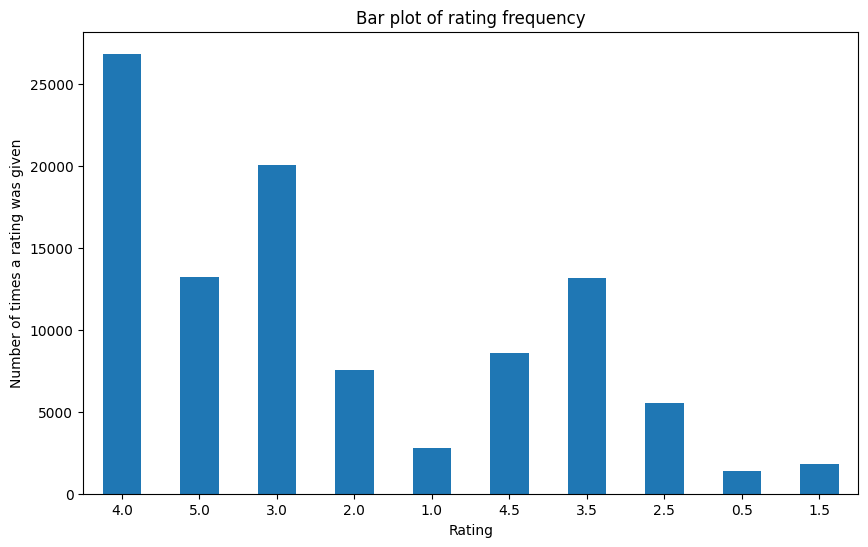

In [9]:
import matplotlib.pyplot as plt

total_dataframe['rating'].value_counts(sort=False).plot(kind='bar' ,figsize=(10,6), use_index = True, rot=0)
plt.title('Bar plot of rating frequency')
plt.xlabel('Rating')
plt.ylabel('Number of times a rating was given')

## It can be seen that most of the users have rewarded movies they watched with a 4 star rating and followed by 3 star and 5 star.

## Pie chart of number of movies with ratings

Split of movies count based on their overall average rating


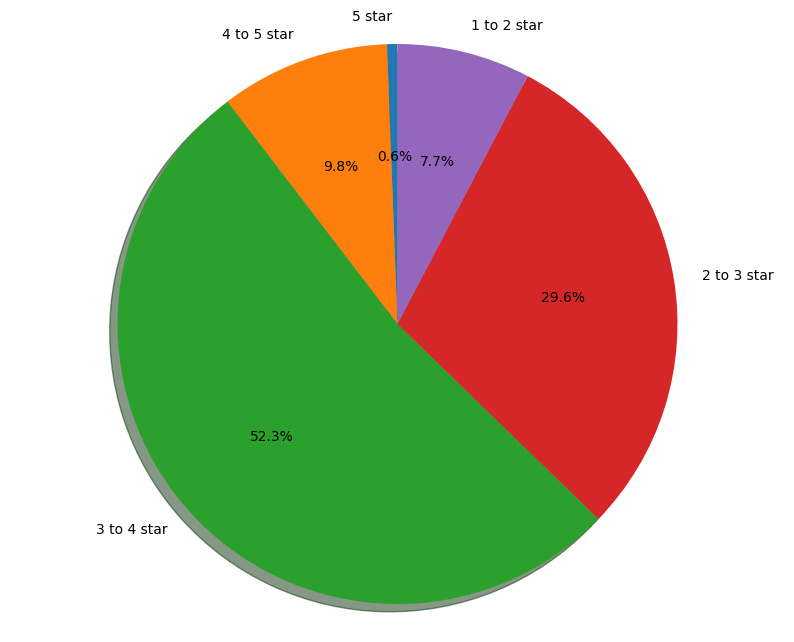

In [10]:
import matplotlib.pyplot as plt

print('Split of movies count based on their overall average rating')
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '5 star', '4 to 5 star', '3 to 4 star', '2 to 3 star', '1 to 2 star'
sizes = [10, 163, 871, 492, 128]

fig1, ax1 = plt.subplots(figsize=(10,8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

## Average ratings per movie

## For this we should merge movie titles with the total dataset first

In [11]:
total_dataset = pd.merge(total_dataframe, movies, how='inner', on='movieId')
total_dataset

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
100831,610,166534,4.0,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,Get Out (2017),Horror
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi


In [12]:
total_dataset.to_csv("entire_dataset.csv", index = False)

In [13]:
avg_highly_rated_movies = total_dataset.groupby(['title']).agg({"rating":"mean"})['rating'].sort_values(ascending=False)
avg_highly_rated_movies = avg_highly_rated_movies.to_frame()

avg_highly_rated_movies.reset_index(level=0, inplace=True)

avg_highly_rated_movies.columns = ['movie title', 'avg rating']
avg_highly_rated_movies.head(10)

,movie title,avg rating
0,Gena the Crocodile (1969),5.0
1,True Stories (1986),5.0
2,Cosmic Scrat-tastrophe (2015),5.0
3,Love and Pigeons (1985),5.0
4,Red Sorghum (Hong gao liang) (1987),5.0
5,"Thin Line Between Love and Hate, A (1996)",5.0
6,Lesson Faust (1994),5.0
7,Eva (2011),5.0
8,Who Killed Chea Vichea? (2010),5.0
9,Siam Sunset (1999),5.0


## Lets see how much people have rated lord of the ring movies

In [14]:
mov_ls = list(avg_highly_rated_movies["movie title"])
l1 = [(k, avg_highly_rated_movies.loc[mov_ls.index(k), "avg rating"]) for k in mov_ls if 'hobbit' in k.lower() or 'lord of the rings' in k.lower()]

# l1 now contains a list of tuples where each tuple has the movie title and its corresponding rating
print(l1)

[('Lord of the Rings: The Return of the King, The (2003)', 4.118918918918919), ('Lord of the Rings: The Fellowship of the Ring, The (2001)', 4.106060606060606), ('Lord of the Rings: The Two Towers, The (2002)', 4.0212765957446805), ('Hobbit: An Unexpected Journey, The (2012)', 3.8125), ('Hobbit: The Desolation of Smaug, The (2013)', 3.58), ('The Hobbit: The Battle of the Five Armies (2014)', 3.4166666666666665), ('Lord of the Rings, The (1978)', 3.1333333333333333)]


# Size of the dataset

In [15]:
total_dataset.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


## Looking at the above the data seems fine 100k